# Strojové učenie: Projekt
---
### Autor: Andrej Kapusta
### Dátum odovzdania: 24.01.2021
---
## Téma projektu

V tomto projekte sa zameriam na analýzu dát, ich predspracovanie a strojové učenie. Pracovať budem s dvomi datasetmi. Prvý dataset obsahuje demografické údaje o pacientoch u ktorých prebehlo vyšetrenie na cukrovku a druhý dataset obsahuje výsledky z vyšetrenia v podobe údajov kyslíka a cukru v krvi a ďalšie doplňujúce informácie. Cieľom tejto práce je identifikovať chyby v dátach, vykonať potrebné predspracovanie a nakoniec natrénovať model, ktorý bude vedieť pre nové pozorovania určiť, či pacient má alebo nemá cukrovku.

---

## Datasety
V rámci projektu sú použité 4 datasety v zložke *data*:
* *personal_train* - trénovací dataset, obsahuje demografické údaje o pacientoch vyšetrených na cukrovku
* *personal_valid* - validačný dataset, obsahuje demografické údaje o pacientoch vyšetrných na cukrovku
* *other_train* - trénovací dataset, obsahuje rôzne agregované hodnoty meraného cukru a kyslíku v krvi, a ine doplňujúce údaje
* *other_valid* - validačný dataset, obsahuje rôzne agregované hodnoty meraného cukru a kyslíku v krvi, a ine doplňujúce údaje

# 1. Analýza dát
---
V prvej časti sa zameriam na analýzu dát, ktoré budú použité pre natrénovanie klasifikátoru. O dátach sa pokúsim zistiť, aké chyby sa v nich nachádzajú a navrhnem scenár ich riešenia. Výsledky tejto analýzy využijem vo fáze predspracovania datasetov.

### Načítanie knižníc

In [1]:
%matplotlib inline
import re
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import data_cleaner as dc
import personal_cleaner as pc
import other_cleaner as oc
import operator
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG, HTML
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

### Načítanie trenovacich datasetov datasetov

In [2]:
personal = pd.read_csv("./data/personal_train.csv", index_col=0)
other = pd.read_csv("./data/other_train.csv", index_col=0)

---
## 1.1 Dataset - *personal_train*
V tejto časti sa zamerivam na prieskumnú analýzu prvého trénovacieho datasetu, ktorý obsahuje osobné údaje o pacientoch, na ktorých boli zaznamenávané dáta pre identifikáciu prítomnosti cukrovky.

### Základné údaje o datasete

|**Počet záznamov**|**Počet neúplných záznamov**|**Počet atribútov**|**Dátové typy atribútov**|
|:----------------:|:--------------------------:|:-----------------:|:-----------------------:|
|3933              |393                         |5                  |float64, object          |

### Údaje o atribútoch

|**Názov**        |**Dátový typ**|**Typ atribútu**|**Počet nenulových záznamov**|
|:---------------:|:------------:|:--------------:|:---:|
|**name**         |object        |nominálny       |3933|
|**address**      |object        |nominálny       |3933|
|**age**          |float64       |numerický       |3540|
|**sex**          |object        |nominálny       |3933|
|**date_of_birth**|object        |ordinálny       |3933|

#### Počet neúplných záznamov

In [3]:
personal.shape[0] - personal.dropna().shape[0]

393

### Analýza atribútu *age*:
---
Pri analýze dát je potrebné sa pozrieť na jednotlivé atribúty a hodnoty ktoré nadobúdajú. Veľmi užitočnou metódou je vizualizácia rozdelenia hodnôt, ktorou sa dajú odhaliť vychýlené hodnoty a prípadne aj vysoká diverzita hodnôt. Pomôcť nám vie aj deskriptívna štatistika numerických atribútov, ktorá vie tiež odhaliť niektoré chyby v dátach. V datasete *personal_train* je len jeden numerický atribút, a jeho štatistika nám ukazuje, že minimálny vek má hodnotu -1 a maximum je 113. Takto nezmyselné hodnoty pomáhajú pri identifikácii problémov. Maximálny zaznamnený vek 113, je pomerne veľký, ale takáto hodnota je stále reálna.

In [4]:
personal.describe()

,age
count,3540.000000
mean,51.838136
std,11.829989
min,-1.000000
25%,44.000000
50%,52.000000
75%,60.000000
max,113.000000


Nasledujúci histogram zachytáva rozdelenie atribútu *age*. Toto rozdelenie môžme považovať za normálne a nie je potrebné robiť žiadne špeciálne korekcie.

<AxesSubplot:ylabel='Frequency'>

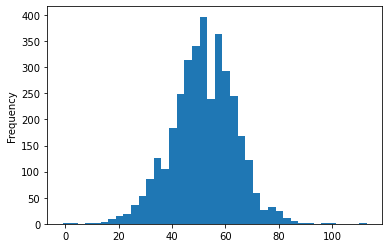

In [5]:
personal.age.plot.hist(bins=40)

### Identifikácia problémov v datasete *personal_train* spolu s predpokladaným scenárom riešenia vo fáze predspracovania
----
Pri základných údajoch o atribútoch som si všimol, že niektoré záznamy majú chýbajúcu hodnotu veku. V nasledujúcej časti ukážem identifikované chyby, ako aj scenár ich riešenia v ďalšej fáze.
#### Chyby v dátach:
* Chýba 393 hôdnôt v stĺpci *age*. Označené sú ako NaN.
* Stĺpec *age* je typu *float*, no pre tento atribút je vhodnejšie použitie *int*.
* Pri jednom zázname je hodnota *age* -1, a rok narodenia pacienta 2021. Toto vyhodnocujem ako nereálnu hodnotu vzhľadom na dátum vykonávania analýzy - Január 2021.

In [6]:
personal[personal['age'] < 0]

,name,address,age,sex,date_of_birth
396,Marvin Johnson,"2918 Jordan Springs\nPort Glenn, MN 91566",-1.0,Male,2021-04-12 00:00:00


* V stĺpci *date_of_birth* sa odlišuje formát dátumu(rôzne separátory, niekde pridaný čas, prehodený deň/mesiac/rok).
Identifikované formáty dátumu:

|**Identifikátor**|**Formáty dátumu narodenia**|
|:---------------:|:--------------------------:|
|**f1**           |yyyy-mm-dd                  |
|**f2**           |yyyy/mm/dd                  |
|**f3**           |dd/mm/yyyy                  |
|**f4**           |yy-mm-dd                    |
|**f5**           |yyyy-mm-dd 00 00 00         |
|**f6**           |yyyy-mm-dd 00:00:00         |

Na základe overenia, som v datasete identifikoval všetky prítomné formáty dátumu.

In [7]:
# Overenie identifikovaných formátov dátumu narodenia
dates = personal['date_of_birth']
f1 = dates[dates.str.match(pat = '^[0-9]{4}-[0-9]{2}-[0-9]{2}$') == True].shape[0]
f2 = dates[dates.str.match(pat = '^[0-9]{4}/[0-9]{2}/[0-9]{2}$') == True].shape[0]
f3 = dates[dates.str.match(pat = '^[0-9]{2}/[0-9]{2}/[0-9]{4}$') == True].shape[0]
f4 = dates[dates.str.match(pat = '^[0-9]{2}-[0-9]{2}-[0-9]{2}$') == True].shape[0]

# f5 a f6
f5 = dates[dates.str.match(pat = '^[0-9]{4}-[0-9]{2}-[0-9]{2} 00.{1}00.{1}00$') == True].shape[0]

print("Suma všetkých záznamov jednotlivých formátov dátumov narodenia: " + str(f1+f2+f3+f4+f5))
print("Suma všetkých záznamov atribútu(dátum narodenia) v datasete: " + str(dates.shape[0]))

Suma všetkých záznamov jednotlivých formátov dátumov narodenia: 3933
Suma všetkých záznamov atribútu(dátum narodenia) v datasete: 3933


**_Formát-1: yyyy-mm-dd_**

In [8]:
personal[personal['date_of_birth'].str.match(pat = '^[0-9]{4}-[0-9]{2}-[0-9]{2}$') == True].head(1)

,name,address,age,sex,date_of_birth
0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\nEast Andrew, OH 53211",52.0,Male,1966-10-27


**_Formát-2: yyyy/mm/dd_**

In [9]:
personal[personal['date_of_birth'].str.match(pat = '^[0-9]{4}/[0-9]{2}/[0-9]{2}$') == True].head(1)

,name,address,age,sex,date_of_birth
10,Robert Grantham,"822 Adams Plains\nNew Karen, AK 92114",41.0,Male,1978/08/31


**_Formát-3: dd/mm/yyyy_**

In [10]:
personal[personal['date_of_birth'].str.match(pat = '^[0-9]{2}/[0-9]{2}/[0-9]{4}$') == True].head(1)

,name,address,age,sex,date_of_birth
1,Ernest Kline,"391 Ball Road Suite 961\nFlowersborough, IN 57550",57.0,Male,15/02/1962


**_Formát-4: yy-mm-dd_**

In [11]:
personal[personal['date_of_birth'].str.match(pat = '^[0-9]{2}-[0-9]{2}-[0-9]{2}$') == True].head(1)

,name,address,age,sex,date_of_birth
13,Terry Reynolds,"0019 Jensen Land Apt. 513\nPort Timothyville, ...",45.0,Male,73-10-26


**_Formát-5: "yyyy-mm-dd 00 00 00" a "yyyy-mm-dd 00:00:00"_**

In [12]:
personal[personal['date_of_birth'].str.match(pat = '^[0-9]{4}-[0-9]{2}-[0-9]{2} 00 00 00$') == True].head(1)

,name,address,age,sex,date_of_birth
19,Steve Ripp,"7629 Ramos Knoll\nOwensmouth, NC 34420",62.0,Female,1956-12-24 00 00 00


In [13]:
personal[personal['date_of_birth'].str.match(pat = '^[0-9]{4}-[0-9]{2}-[0-9]{2} 00:00:00$') == True].head(1)

,name,address,age,sex,date_of_birth
4,Anthony Colucci,"904 Robert Cliffs Suite 186\nWest Kyle, CO 77139",61.0,Female,1958-04-15 00:00:00


* Dataset už obsahuje vlastný stĺpce indexov(Unnamed:0) - Vyriešené pri načítaní datasetu(definovanie indexu).
* Hodnoty v stĺpci *address* majú zlé formátovanie - obsahujú rozne údaje(ulica, mesto, štát).

In [14]:
personal.address.tail(5)

3928                 8582 Lee Roads\nCostaburgh, SC 21897
3929    68430 Erik Terrace Suite 279\nPort Adamborough...
3930                     Unit 8416 Box 3801\nDPO AE 31166
3931       34420 Brian Stream\nLake Michaeltown, MS 01832
3932                     Unit 7931 Box 0601\nDPO AE 50505
Name: address, dtype: object

* Stĺpec *sex* nadobúda hodnoty *Male* a *Female*, no na ich začiatku sa nachádzajú medzery.

In [15]:
personal.sex.unique()

array([' Male', ' Female'], dtype=object)

#### Scenár riešenia:
* Atribútu *age* treba zmeniť dátový typ z *float* na *int*.
* Hodnoty v stĺpci *address* treba rozdeliť a vložiť do nových stĺpcov.
* Pri načítaní dát nastavujem ako index dataframe-u stĺpec *Unnamed*. *(Riešenie je zavedné už v úvode notebook-u pri načítaní datasetov)*
* Hodnoty v stĺpci *date_of_birth* treba naparsovať skriptom do rovnakého formátu(napr. yyyy-mm-dd).
* Chýbajúce hodnoty v stĺpci *age* je potrebné nahradiť na základe roku narodenia pacienta.
* Záznam so zápornou hodnotou v stĺpci *age* a rokom narodenia pacienta 2021 je potrebné vyhodiť z dát, pretože je nereálny.
* V hodnotách v stĺpci *sex* treba vymazať medzery - biele znaky.

#### Detekcia duplicít v datasete *personal*
V datasete som neidentifikoval žiadne duplicity.

In [16]:
try:
  pd.concat(g for _, g in personal.groupby("name") if len(g) > 1)
except:
  print("Duplicity v datasete neboli najdene.")

Duplicity v datasete neboli najdene.


---
## 1.2 Dataset - *other_train*
V tejto časti sa budem venovať prieskumnej analýze druhého trenovacieho datasetu, ktorý obsahuje meno a adresu pacienta, výsledky meraných veličín(hladina cukru a kyslíka v krvi), ktoré boli spracované pomocou rôznych agregačných funkcií ako je priemer, štandardná odchýkla, koeficient asymetrie a koeficient špicatosti. Zároveň dátová sada obsahuje rôzne základné informácie o pacientovi, ktoré by mohli byť faktormi pri vzniku ochorenia.

Nezávislým testom bola vyhodnotená skutočná prítomnosť ochorenia u pacienta. Táto je uložená v stĺpci *class*.

### Základné údaje o datasete

|**Počet záznamov**|**Počet atribútov**|**Dátové typy atribútov**|**Počet neúplných záznamov**|
|:----------------:|:-----------------:|:-----------------------:|:--------------------------:|
|3983              |21                 |float64, object   |85                          |


### Údaje o atribútoch

|**Názov**        |**Dátový typ**|**Typ atribútu**|**Počet nenulových záznamov**|
|:------------------:|:------------:|:--------------:|:---:|
|**name**            |object        |nominálny       |3983 |
|**address**         |object        |nominálny       |3983 |
|**kurtosis_oxygen** |float64       |numerický       |3963 |  
|**pregnant**        |object        |nominálny       |3968 |
|**education-num**   |float64       |ordinálny       |3978 |
|**relationship**    |object        |nominálny       |3969 |
|**skewness_glucose**|float64       |numerický       |3969 |
|**mean_glucose**    |float64       |numerický       |3966 |
|**std_oxygen**      |float64       |numerický       |3973 |
|**capital-gain**    |float64       |numerický       |3966 |
|**skewness_oxygen** |float64       |numerický       |3967 |
|**kurtosis_glucose**|float64       |numerický       |3974 |
|**personal_info**   |object        |nominálny       |3968 |
|**education**       |object        |nominálny       |3969 |
|**fnlwgt**          |float64       |numerický       |3961 | 
|**class**           |float64       |nominálny       |3972 |
|**std_glucose**     |float64       |numerický       |3967 |
|**income**          |object        |ordinálny       |3969 |
|**mean_oxygen**     |float64       |numerický       |3969 |
|**hours-per-week**  |float64       |numerický       |3962 |
|**capital-loss**    |float64       |numerický       |3972 |

#### Počet neúplných záznamov

In [17]:
other.shape[0] - other.dropna().shape[0]

85

### Deskriptívna štatistika
V nasledujúcej tabuľke sa nachádza základná štatistika všetkých numerických atribútov datasetu *other*. Z tabuľky sa síce nedajú vyčítať dôležité údaje o atribútoch, no na prvý pohľad môžme vidieť, že v datasete sa nachádzajú zvláštne hodnoty, ktoré treba podrobnejšie analyzovať. Atribút *capital-gain* má maximálnu hodnotu *99999.00*, ktorá sa javí zvláštne. Ďalej atribút *mean_glucose* má medzi maximálnou a minimálnou hodnotou veľmi veľký rozdiel*(max = 16655.47, min = -15187.50)*. Na analýzu atribútov datasetu budeme potrebovať rôzne grafové vizualizácie, ktoré pomôžu odhaliť problémy v dátach.

In [18]:
other.describe()

,kurtosis_oxygen,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,kurtosis_glucose,fnlwgt,class,std_glucose,mean_oxygen,hours-per-week,capital-loss
count,3963.000000,3978.000000,3969.000000,3966.000000,3973.000000,3966.000000,3967.000000,3974.000000,3.961000e+03,3972.000000,3967.000000,3969.000000,3962.000000,3972.000000
mean,7.433554,10.104575,4.199759,44.479864,31.094749,1005.652042,91.844519,0.947481,1.893604e+05,0.254280,45.185639,18.389716,40.697627,92.125629
std,4.824271,2.596224,9.651822,3386.419512,22.249393,6831.299352,109.278370,1.606288,1.055450e+05,0.435511,7.609055,34.674304,12.539196,413.629253
min,-2.597872,1.000000,-1.755332,-15187.500000,7.370432,0.000000,-1.976976,-1.641515,1.487800e+04,0.000000,25.695250,0.213211,1.000000,0.000000
25%,3.668706,9.000000,-0.122530,83.460938,15.023404,0.000000,12.952758,0.071712,1.179060e+05,0.000000,40.168984,2.061873,40.000000,0.000000
50%,7.801335,10.000000,0.373241,110.488281,20.503977,0.000000,68.776486,0.310279,1.784890e+05,0.000000,45.894825,3.224916,40.000000,0.000000
75%,10.269211,13.000000,2.080411,125.341797,43.124802,0.000000,127.249164,0.774300,2.363960e+05,1.000000,50.376889,12.605351,45.000000,0.000000
max,34.539844,16.000000,68.101622,16655.468750,110.642211,99999.000000,1191.000837,8.069522,1.097453e+06,1.000000,91.206475,217.371238,99.000000,2603.000000


### Atribúty datasetu *other*
---
Podrobnú analýzu atribútov (rozdelenia, potreby normalizácie, outliery) uvádzam v druhej časti tohto projektu - Predspracovanie.

### Identifikácia problémov v datasete *other* spolu s predpokladaným scenárom riešenia vo fáze predspracovania
---

#### Chyby v dátach:
* Dataset už obsahuje vlastný stĺpce indexov(Unnamed:0) - Vyriešené pri načítaní datasetu(definovanie indexu).
* Záznamy v stĺpcoch *relationship*, *education* obsahújú biele znaky. Zároveňv hodnoty v stĺpci *relationships* majú nekonzistentný formát('-' namiesto '_').


In [19]:
other.relationship.unique()

array([' Husband', ' Not-in-family', ' Own-child', ' Unmarried',
       ' Not_in_family', ' Wife', ' Own_child', ' Other-relative', nan,
       ' Other_relative'], dtype=object)

In [20]:
other.education.unique()

array([nan, ' Some-college', ' HS-grad', ' 1st-4th', ' Masters', ' 10th',
       ' Assoc-voc', ' Bachelors', ' Assoc-acdm', ' 12th', ' 7th-8th',
       ' 11th', ' 9th', ' Doctorate', ' Prof-school', ' Preschool',
       ' 5th-6th'], dtype=object)

* Hodnoty v stĺpci *address* majú zlé formátovanie - obsahujú rozne údaje(ulica, mesto, štát).

In [21]:
other.address.head()

0    13693 Tiffany Springs\r\nNorth Ericbury, CA 68355
1    9853 Sims Tunnel Apt. 990\r\nNorth Katherinebu...
2     4510 Evan Forest\r\nSouth Richardshire, AZ 81721
3         63159 Scott River\r\nSouth Beverly, IL 94155
4                   Unit 4369 Box 7730\r\nDPO AA 41687
Name: address, dtype: object

* Stĺpec *class* je typu *float*, no pre tento atribút je vhodnejšie použitie *int*. Zároveň je *class* keyword v jazyku python, čo sťažuje prácu.

In [22]:
other['class'].dtypes

dtype('float64')

* Stĺpec *education-num* je typu *float*, no pre tento atribút je vhodnejšie použitie *int*.

In [23]:
other['education-num'].dtypes

dtype('float64')

* Názvy stĺpcov nie sú konzistentné a zrozumiteľné.('-' namiesto '_')

In [24]:
other.columns

Index(['name', 'address', 'kurtosis_oxygen', 'pregnant', 'education-num',
       'relationship', 'skewness_glucose', 'mean_glucose', 'std_oxygen',
       'capital-gain', 'skewness_oxygen', 'kurtosis_glucose', 'personal_info',
       'education', 'fnlwgt', 'class', 'std_glucose', 'income', 'mean_oxygen',
       'hours-per-week', 'capital-loss'],
      dtype='object')

* V stĺpci *pregnant* je konzistentnosť vo formáte príznakov(TRUE/T/t, FALSE/F/f).

In [25]:
other.pregnant.unique()

array([nan, 'f', 'F', 'FALSE', 'TRUE', 't', 'T'], dtype=object)

* Chýba veľa hodnôt v mnohých atribútoch.
* V stĺpci *capital-gain* existuje outlier.
* V stĺpci *personal_info* sa nachádza viacero údajov, ktoré je potrebné oddeliť(pracovná pozícia, krajina, rodinný stav...).

In [26]:
other.personal_info[0]

'Craft-repair|United-States\r\r\nMarried-civ-spouse -- Self-emp-not-inc|Asian-Pac-Islander'

#### Scenár riešenia:
* Ujednotenie názvov stĺpcov.
* Odstránenie bielych znakov v atribútoch *relationship* a *education*.
* Upravenie záznamov v atribúte *relationship* do rovnakého formátu.
* Rozdelenie hodnôt atribútu *address* do viacerých, nových atribútov(napr. ulica, mesto, štát).
* Zmena typu atribútu *class* a *education-num* z *float* na *int*.
* Zjednotenie formátu hodnôt pre atribút *pregnant*(T, F).
* Doplnenie chýbajúcich hodnôt na základe rozdelenia atribútu, resp. na základe priľahlých hodnôt iných záznamov.
* Rozdelenie hodnôt atribútu *personal_info* do viacerých, nových atribútov(napr. povolanie, krajina, rodinný stav, rasa...).
* Úprava rozdelení atribútov, a nahradenie hodnôt outlierov priemerom alebo mediánom.

#### Detekcia duplicít v datasete *other*
Ako môžeme vidieť nižšie, v datasete *other* sa nachádzajú duplicitné záznamy. Je dôležité si všimnúť, že pri jednotlivých dvojiciach chýbajú v ich záznamoch rôzne hodnoty. Riešením týchto duplicitných záznamov je deduplikácia, ktorú by som chcel realizovať na základe presnej zhody na kľúčových atribútoch ako je *name* a *address*. Pri tomto procese však bude potrebné zlúčiť záznamy tak, aby sa čo najviac znížil počet *NaN* hodnôt.

In [27]:
try:
  pd.concat(g for _, g in other.groupby("name") if len(g) > 1)
except:
  print("Duplicity neboli najdene")
  
pd.concat(g for _, g in other.groupby("name") if len(g) > 1)

,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,kurtosis_glucose,personal_info,education,fnlwgt,class,std_glucose,income,mean_oxygen,hours-per-week,capital-loss
1956,Carlton Redden,"PSC 3174, Box 2300\r\nAPO AA 42041",6.592571,f,13.0,Husband,0.279443,103.492188,25.794207,NaN,NaN,0.261139,Sales|United-States\r\r\nMarried-civ-spouse --...,Bachelors,NaN,0.0,NaN,NaN,4.470736,45.0,0.0
2134,Carlton Redden,"PSC 3174, Box 2300\r\nAPO AA 42041",6.592571,f,13.0,NaN,0.279443,103.492188,25.794207,0.0,45.928570,0.261139,Sales|United-States\r\r\nMarried-civ-spouse --...,Bachelors,303954.0,0.0,44.114375,<=50K,4.470736,45.0,0.0
2239,Chris Reeve,9137 Shane Island Suite 140\r\nChristophervill...,9.890430,f,9.0,NaN,1.360047,-9157.031250,14.341180,NaN,122.363440,0.850379,?|United-States\r\r\nNever-married -- ?|White,HS-grad,170994.0,0.0,46.576665,<=50K,1.927258,40.0,0.0
3920,Chris Reeve,9137 Shane Island Suite 140\r\nChristophervill...,9.890430,f,9.0,Not-in-family,1.360047,NaN,14.341180,0.0,122.363440,0.850379,?|United-States\r\r\nNever-married -- ?|White,HS-grad,170994.0,NaN,46.576665,NaN,1.927258,40.0,0.0
227,Christopher Harrison,"392 Sullivan Overpass\r\nNorth James, NE 07664",NaN,f,10.0,Unmarried,0.717945,101.960938,19.305105,NaN,99.235553,0.324672,Adm-clerical|United-States\r\r\nDivorced -- Pr...,Some-college,155233.0,0.0,42.646513,NaN,2.112876,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2597,William Billings,"93781 Deborah Divide Apt. 659\r\nJacobsport, N...",12.514518,f,14.0,Husband,0.536245,106.710938,NaN,0.0,174.793062,NaN,Prof-specialty|United-States\r\r\nMarried-civ-...,Masters,75867.0,0.0,46.500026,<=50K,NaN,60.0,0.0
768,William Simpson,"279 Perry Forks Apt. 179\r\nLake Julie, DC 89693",9.086361,f,13.0,Husband,-0.279978,117.875000,15.103930,0.0,107.835518,0.171736,Craft-repair|United-States\r\r\nMarried-civ-sp...,Bachelors,20956.0,0.0,54.222775,<=50K,2.596154,40.0,1740.0
2833,William Simpson,"279 Perry Forks Apt. 179\r\nLake Julie, DC 89693",NaN,NaN,13.0,NaN,-0.279978,117.875000,15.103930,0.0,107.835518,0.171736,Craft-repair|United-States\r\r\nMarried-civ-sp...,Bachelors,NaN,0.0,NaN,<=50K,2.596154,40.0,NaN
0,Willie Robinson,"13693 Tiffany Springs\r\nNorth Ericbury, CA 68355",14.066041,NaN,11.0,Husband,2.120131,NaN,11.351053,2885.0,NaN,NaN,Craft-repair|United-States\r\r\nMarried-civ-sp...,NaN,101709.0,0.0,35.573729,<=50K,1.152174,NaN,0.0


# 2. Predspracovanie dát
---

## 2.1 Čistenie datasetu *personal*

Pre vyčistenie datasetu *personal* boli vytvorené python skripty, ktoré realizujú navrhnuté zmeny v rámci analýzy dát. V prípade datasetu *personal* sa na čistenie používa skript *personal_cleaner.py*. Tento modul obsahuje metódu *clean_data*, ktorej vstupné atribúty sú trénovací a validačný dataset *personal*, a výstupom su obidva vyčistené datasety. V nasledujucej tabuľke zhŕňam realizované zmeny v rámci predspracovania.

**Transformácie nad datasetom:**

|**Transformácia**|**Názov atribútu**|**Funkcia/operácia**|
|-----------------|----------------:|:--------------:|
|Zjednotenie formátu dátumu narodenia. |date_of_birth|fix_dates(data)|
|Doplnenie a veku na základe roku narodenia. |age|fill_nan_age(data)|
|Zmena dátového typu atribútu *age* z float na int. |age|convert_age_type(data)|
|Rozdelenie atribútu atribútu *address* na *address, city a state* |address|split_address(text)|
|Vymazanie bielych znakov z hodnôt atribútu *sex*. |sex|data = fix_sex(data)|
|Odstránenie záznamov, pre ktoré nebolo možné vhodným <br> spsôsobom určiť chýbajúcu hodnotu veku - chybny datum. |date_of_birth|drop_invalid_date(data)|

Vytvorené funkcie na transformáciu datasetu *personal* v module *personal_cleaner.py* nemajú štruktúru *fit/transform*, pretože v prípade prítomných atribútov to nebolo potrebné realizovať. Pri dopĺňaní hodnôt atribútu *age* využívam hodnotu atributu dátumu narodenia, ktorý prislúcha rovankému záznamu a preto nie je potrebné si uchovávať žiadnu hodnôtu pre predspracovanie validačného datasetu *personal*.

## 2.2 Čistenie datasetu *other*

Zmeny v dátach boli vykonané na základe analýzy z predchádzajúcej fázy projektu. Na vyčistenie datasetu je použitý modul *other_cleaner.py*, ktorý obsahuje funkcie, ktoré boli vytvorené na transformáciu príslušných dát resp. atribútov. Tento modul obsahuje metódu *clean_data*, ktorej vstupné atribúty sú trénovací a validačný dataset *other*, a výstupom su obidva vyčistené datasety.

### Atribúty *name, address, city, state*
Z pôvodného atribútu *address* sú v predspracovaní vyvodené ďalšie dva atribúty a to *city* a *state*. Pri ich vytváraní nevznikli žiadne *nan* alebo iné nepriaznivé hodnoty, preto tieto kategorické dáta nebolo potrebné nijak inak upravovať. Rovnako tak nebolo potrebné upravovať atribút *name*. Atribúty *name, address* sú v predspracovaní využité na odstránenie duplicít.

### Atribút *pregnant*
Pri atribúte pregnant som ujednotil formát hodnot na *T(true)* a *F(false)*. 
V prípade NaN hodnoty som doplinil príznak *F*, nakoľko nebolo možné určiť reálnu hodnotu tohto atribútu.
Z pozorovania som však nezaznamenal, že by existoval záznam s chýbajúcou hodnotou u ženského pohlavia, a pre mužov je hodnota *F* validná. Nakoniec som hodnoty atribútu pretransformoval na binárny numerický atribút, kde *T=1* a *F=0*.

### Atribút *relationship*
Neznáme hodnoty v atribúte *relationship* som označil ako *Unknown*.

### Atribút *hours_per_week*
Pre tento atribút som vytvoril triedu s metódami *fit* a *transform*, pre vloženie NaN hodnôt na základe vypočítaného mediánu. Táto natrénovaná hodnota bude potom opätovne použitá aj pri predspracovaní validačného datasetu. Po doplnení hodnôt som zmenil dátovy typ z float na int.

### Atribút *class*
Tento atribút obsahuje označenie, či pacient má alebo nemá cukrovku. Je smerodatný pri predikci cukrovky, a preto nemôžme akýmkolvek spôsobom tieto hodnoty nahradiť. Nakoľko bolo takýchto záznamov málo, rozhodol som sa ich z datasetu odstraniť.

### Atribút *income*
Pri tomto atribúte som doplnil NaN hodnoty, ktorých počet bol v jednotkách, automaticky početnejšou hodnotou a to  *'<=50K'*. Následne som tento atribút transformoval na numerický s použitím binárneho mapovania. Po úprave su hodnoty reprezentované následovne: *'<=50K' - 0* a *'>50K' - 1*.

### Atribúty *education* a *education_num*
Medzi atribútmi *education* a *education_num* som našiel dokonalé mapovanie, ktoré potvrdzuje nasledovná tabuľka pre spomínané atribúty. Tabuľka zachytáva množstvo výskytov jednotlivých hodnôt. Na základe tejto infomácie viem nahradiť NaN hodnoty v príslušných stĺpcoch, ak druhý atribút bude obsahovať hodnotu. Nakoľko by tak oba stlpce boli dokonalo namapované, význam atributu *education* sa stráca. Preto ponechávam len atribút *education_num* a k hodnote education sa potom dá kedykolvek spätne dostať.

In [28]:
pd.set_option('display.max_columns', 50)
pd.crosstab(other.education, other['education-num'])

education-num,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
education,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,105,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,128,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,44,0,0,0,0,0,0,0,0
1st-4th,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5th-6th,0,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,82,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,71,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,134,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,153,0,0,0,0,0


### Atribúty *occupation, country, marital, workclass, race*
Tieto atribúty boli vytvorené pri rozdelení dát v atribúte *personal_info*. Niektoré záznamy však neboli úplné, a boli nahradné hodnout '?', '??' alebo 'nan'. Tieto hodnoty som označil ako *Unknown*. Táto úprava by nemala mať signifikantný vplyv na trénovanie modelu a jeho validáciu. Kategorické atribúty o ktorých hovorím nebolo možné doplniť dôveryhodným spôsobom.

### Atribút *std_glucose* a jeho normalizácia

Na základe zobrazeného histogramu a hodnoty skewness môžme povedať, že rozdelenie je takmer symetrické. Preto má zmysel pozrieť sa aj na boxplot, ktorý vie v prípade normálneho rozdelenia odhaliť outlier-ov.

<AxesSubplot:>

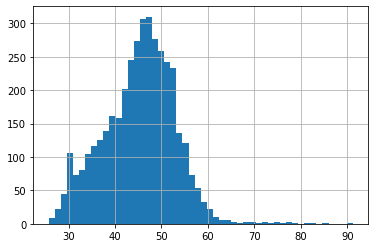

In [29]:
other['std_glucose'].hist(bins=50)

Z boxplotu môžeme vidieť, že hodnoty nad 65 sú identifikované ako outlier-y. Túto hodnotu predstavuje pravý fúz boxplotu.

<AxesSubplot:xlabel='std_glucose'>

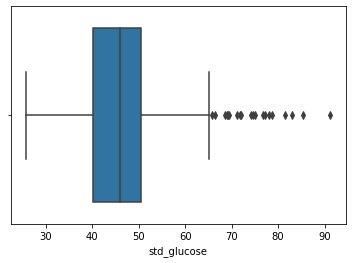

In [30]:
sns.boxplot(other['std_glucose'])

In [31]:
descr = other['std_glucose'].describe()
whisker_r = np.min([descr['max'], descr['75%'] + (1.5 * (descr['75%'] - descr['25%']))])
whisker_l = np.max([descr['min'], descr['25%'] - (1.5 * (descr['75%'] - descr['25%']))])
whisker_l, whisker_r

(25.69524955, 65.688745125)

Hodnoty väčšie ako 65 nahradím hodnotou 95 percentilom. Na histograme môžeme vidieť normálne rozdelenie a boxplot už nezachytáva žiadne vychýlené hodnoty. Táto normalizácia je implementovaná tak, že ak by sa vyskytli ouliere aj na ľavej strane, hodnoty budu nahradené 5 percentilom. Na boxplote po normalizácii už nie su zachytené žiadne vychýlené hodnoty. Zistené hranice rozdelenia budú použité v rámci skriptov, ktoré budú realizovať finálne predspracovanie datasetov.

<AxesSubplot:>

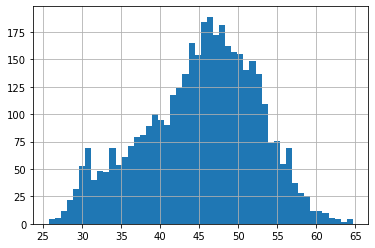

In [32]:
# Normalizacia vychylenych hodnot - nahradenie 95 kvantilom
percentile = other['std_glucose'].quantile(q=0.95)
mask = (other['std_glucose'] > 65)
other.loc[mask, 'std_glucose'] = percentile
other['std_glucose'].hist(bins=50)

<AxesSubplot:xlabel='std_glucose'>

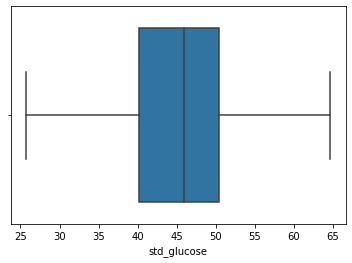

In [33]:
sns.boxplot(other.std_glucose)

### Atribút *mean_glucose* a jeho normalizácia

Z nasledujúceho histogramu a hodnoty skewness môžeme vidieť, že rozdelenie atribútu *mean_glucose* nie je symetrické. Väčšina hodnôt bola identifikovaná v intervale medzi 0-200. Vychýlené hodnoty nadobúdajú príliš vysoké hodnoty, ktoré boli pravdepodobne modifikované vynásobením čísla 100 alebo -100. Nakoľko ide o agregované hodnoty cukru priemerom, záporné hodnoty sú v tomto prípade nereálne a preto ich transformujem na kladné.

<AxesSubplot:>

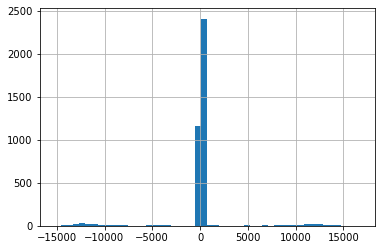

In [34]:
other['mean_glucose'].hist(bins=50)

Na tomto histograme sú znázornené hodnoty atribútu *mean_glucose* v rozsahu 0-175.

<AxesSubplot:>

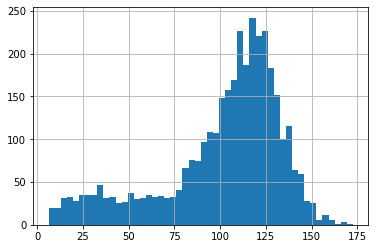

In [35]:
other[(other['mean_glucose'] > 0) & (other['mean_glucose'] < 175)]['mean_glucose'].hist(bins=50)

Po normalizácii hodnôt si možme všimnúť, že histogram hodnôt atribútu sa takmer zhoduje s histogramom rozsahu, z ktorého sme vychádzali že hodnoty patria.

In [36]:
# Normalizácia vychylených hodnôt - delenie parametrom p=100
mask_bigger = (other['mean_glucose'] > 175 )
mask_smaller = (other['mean_glucose'] < 0 )
other.loc[mask_bigger, 'mean_glucose'] = other.loc[mask_bigger, 'mean_glucose'] / 100
other.loc[mask_smaller, 'mean_glucose'] = other.loc[mask_smaller, 'mean_glucose'] / (-100)

<AxesSubplot:>

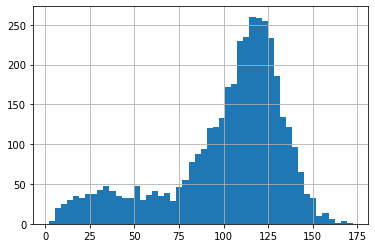

In [37]:
other['mean_glucose'].hist(bins=50)

### Atribút *skewness_glucose* a jeho normalizácia

Histogram ďalšieho atribútu nemá normálne rozdelenie ale ide o long tail rozdelenie. Nakoľko je rozsah hodnôť dosť veľký a väčšina hodnôt sa sústredí v okolí 0, použil som normalizáciu logaritmickou funkciou, ktorou sa zníži tento rozsah.

<AxesSubplot:>

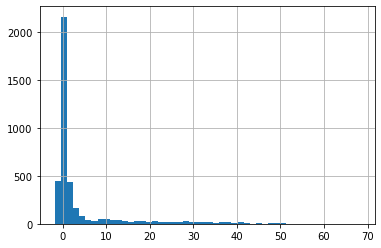

In [38]:
other['skewness_glucose'].hist(bins=50)

<AxesSubplot:>

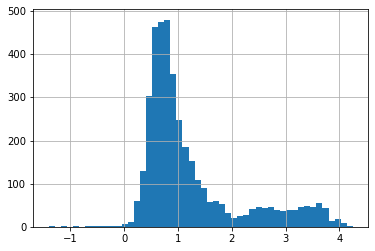

In [39]:
transformed = np.log(other['skewness_glucose']+2)
pd.Series(transformed).hist(bins=50)

### Atribút *kurtosis_glucose* a jeho normalizácia

Ďalší atribút rovanko nedisponuje normálnym rozdelením, ale long tail rozdelením. Na normalizáciu hodnôt som použil posun hodnôt o 2 odmocninu. V tomto prípade nenastala až príliš veľká zmena v rozdelení.

<AxesSubplot:>

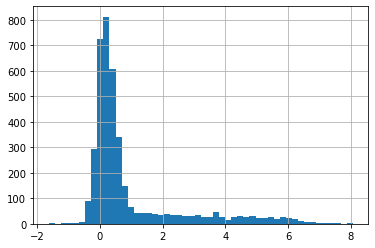

In [40]:
other['kurtosis_glucose'].hist(bins=50)

<AxesSubplot:>

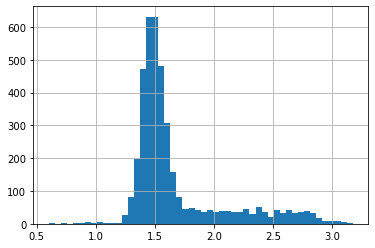

In [41]:
transformed = np.sqrt(other['kurtosis_glucose']+2)
pd.Series(transformed).hist(bins=50)

### Atribút *kurtosis_oxygen* a jeho normalizácia

Parameter kurtosis_oxygen má pomerne dobrú krivku. Skúsil som však všetky čísla posunúť o určitu hodnotu doprava, aby som sa zbavil záporných čísel. Posunutie hodnôt som spravil na základe minimálnej hodnoty.

<AxesSubplot:>

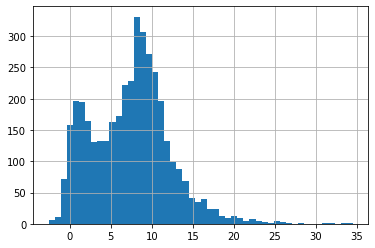

In [42]:
pd.Series(other.kurtosis_oxygen).hist(bins=50)

In [43]:
other["kurtosis_oxygen"].min()

-2.597871861

V nasledujúcej transformácii posúvam všetky hodnoty o 3 vzhľadom na nájdene minimum. Normalizáciu hodnôt realizujem v tomto prípade pomocou odmocniny. Skúšal som aj transformáciu dát pomocou logaritmickej transformácie, no tá nebola veľmi efektívna. 

<AxesSubplot:>

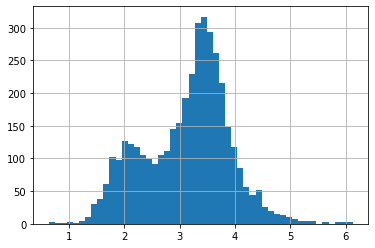

In [44]:
transformed = np.sqrt(other["kurtosis_oxygen"]+3)
pd.Series(transformed).hist(bins=50)

Transformované dáta sa približujú k normálnemu rozdeleniu a preto som sa pozrel aj na možné outlier-e pomocou boxplot-u. Vychýlené hodnoty boli identifikované aj na ľavo aj na pravo. Postup opakujem rovnako ako v prípade atribútu *std_glucose*, teda identifikujem hranice rozdelenia a odľahlé hodnoty nahradim 5 alebo 95 kvantilom.

<AxesSubplot:xlabel='kurtosis_oxygen'>

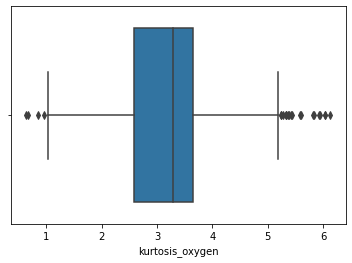

In [45]:
sns.boxplot(transformed)

In [46]:
descr2 = (transformed).describe()
whisker2_r = np.min([descr2['max'], descr2['75%'] + (1.5 * (descr2['75%'] - descr2['25%']))])
whisker2_l = np.max([descr2['min'], descr2['25%'] - (1.5 * (descr2['75%'] - descr2['25%']))])

In [47]:
sum(transformed > whisker2_r)

19

In [48]:
sum(transformed < whisker2_l)

4

Atribút obsahuje 23 outlierov, ktoré budú nahradené.

### Atribút *std_oxygen* a jeho normalizácia

Pri tomto atribúte môžme pozorovať long tail rozdelenie. Na normalizáciu dát použijem v tomto prípade logaritmickú funkciu.

<AxesSubplot:>

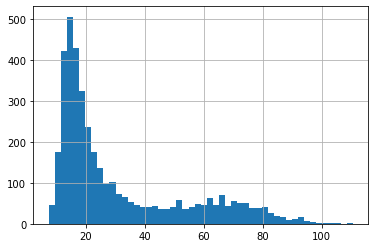

In [49]:
pd.Series(other.std_oxygen).hist(bins=50)

<AxesSubplot:>

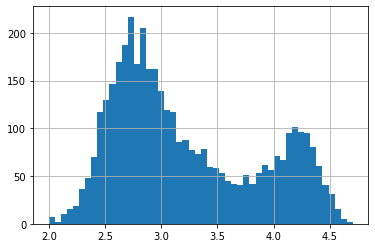

In [50]:
transformed = np.log(other.std_oxygen)
pd.Series(transformed).hist(bins=50)

Na overenie prítomnosti outlierov som sa pozrel aj na boxplot, ktorý nanaznačuje žiadne vychýlené hodnoty.

<AxesSubplot:xlabel='std_oxygen'>

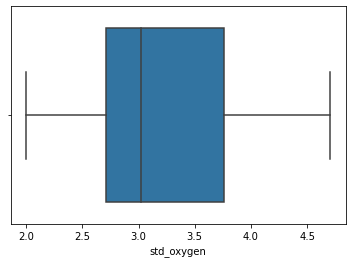

In [51]:
sns.boxplot(transformed)

Atribút std_oxygen po normalizácií neobsahuje žiadne hodnoty, ktoré by bolo potrebné nahradiť, upraviť alebo odstrániť.

### Atribút *skewness_oxygen* a jeho normalizácia

Atribút nadobúda najväčšie množstvo hodnôt v rozsahu cca od 0 po 30. Taktiež môžeme vidieť, že ide skôr o long tail rozdelenie. Atribút má aj záporné hodnoty, a preto som urobil posun hodnôt. Nad takto upravenými dátami som použil logaritmickú funckiu na normalizáciu hodnôt.

<AxesSubplot:>

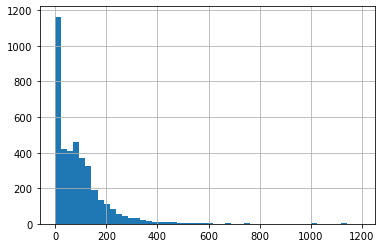

In [52]:
pd.Series(other.skewness_oxygen).hist(bins=50)

In [53]:
other.skewness_oxygen.min()

-1.976975603

<AxesSubplot:>

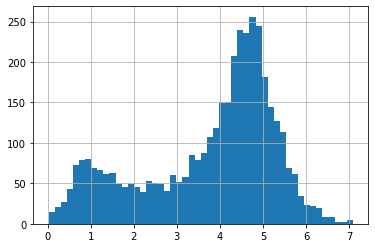

In [54]:
transformed = np.log(other["skewness_oxygen"]+3)
pd.Series(transformed).hist(bins=50)

### Atribút *mean_oxygen* a jeho normalizácia

Pri tomto atribútu opäť pozorujem long tail rozdelenie. Na normalizáciu používam logaritmickú funkciu.

<AxesSubplot:>

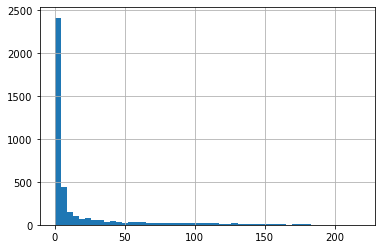

In [55]:
pd.Series(other.mean_oxygen).hist(bins=50)

<AxesSubplot:>

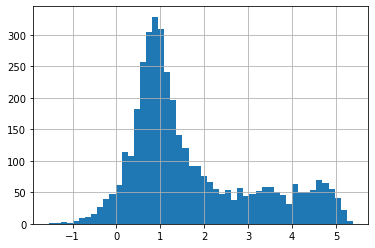

In [56]:
transformed = np.log(other["mean_oxygen"])
pd.Series(transformed).hist(bins=50)

### Nahrádzanie NaN hodnôt
---
V rámci datasetu sa pri numerických atribútoch vyskytujú chýbajúce hodnoty NaN. V rámci predspracovania som zvolil stratégiu doplnenia týchto hodnôt na základe mediánu a priemeru hodnôt daného atribútu. Medián a priemer môžu nadobúdať podobné hodnoty, ale rozhodol som sa vyskúšať ich kombináciu. Nahrádzanie realizujú implementované moduly *imputer_median.py* a *imputer_average.py*.

### Odstránenie outlier-ov
---
V predchádzajúcej časti bolo načrtnuté, že pri atribútoch *std_glucose* a *kurtosis_oxygen*, je potrebné odstrániť outlierov. Túto funkcionalitu v rámci predspracovania zabezpečuje modul *remove_ouliers.py*.

## 2.3 Zvyšné časti predspracovania
---
### Deduplikácia záznamov
---
Pri analýze datasetu *other* boli nájdené duplicitné záznamy. Pri predspracovaní datasetu je preto potrebná ich deduplikácia. Tá prebieha tak, že nájdené duplicitné záznamy sa zlúčia podľa mena, prvý záznam sa ponechá a zvyšné sa vymažú. Pred vymazaním sa z týchto záznamov zachovajú hodnoty a nahradia NaN hodnoty v zázname ktorý sa zachová. Takto sa eliminuje strata potenciálne dôležitých údajov.

### Princíp predspracovania
---
Pre riešenie problémov strojového učenia budem potrebovať trénovacie a validačné dáta, ktoré už sú rozdelené v osobitných datasetoch. Pri predspracovaní však dochádza ku rôznym transformáciam, ktoré boli navrhnuté vzľadom na pozorovania v trénovacom datasete. Pre spracovaní validačného datasetu je potrebné postupovať rovnako ako pri trénovacom datasete, a teda treba použiť natrénové transformácie a nevytvárať nové. Toto v rámci implementácie zabezpečujú funckie *fit* a *transform*. Transformácia sa natrenuje na trenovacich dátach a potom sa použije na validačných dátach. Tento princíp sa uplatňuje aj pri prevode kategorických atribútov na numerické.

### Spojenie datasetov *personal* a *other*
---
Pre spojenie datasetov *personal* a *other* používam funckiu *pandas.merge*. Aby som vedel na seba záznamy čo najlepšie namapovať, použil som ich atribúty *name, address, city a state*. Po spájaní je plánované odstránenie atribútov *name a address* pretože pri trénovaní a testovaní modelu nebudú mať žiaden zmysel. Po spájani môžu vzniknuť záznamy, ktoré v druhom datasete nemali hodnoty, a pri dodatočnom čistení sú potom odstránené.

### Predvod kategorických hodnôt na numerické
---
Niektoré atribúty boli prevedené na numerické už pri predspracovaní. Ide konkrétne o atribúty *pregnant a income*. Bolo pri nich použité binárne kódovanie s jasným predpisom, a preto nie je potrebné využívať metódy fit a transform. V nasledujúcej tabuľke uvádzam spôsob prevodu kategorického atribútu na numerický.

|**Atribút**  |**Spôsob prevodu**|**Poznamka**                  |
|:-----------:|:----------------:|:----------------------------:|
|sex          |binarne           |**1**: Male a **0**: Female   |
|pregnant     |binarne           |**1**: T a **0**: F           |
|income       |binarne           |**1**: '>50K' a **0**: '<=50K'|
|race         |one-hot           |                              |
|relationship |one-hot           |                              |
|marital      |one-hot           |                              |
|occupation   |one-hot           |                              |
|workclass    |one-hot           |                              |
|country      |hash              |                              |
|city         |hash              |                              |
|state        |hash              |                              |
|date_of_birth|hash              |                              |


### Finálne predspracovanie trénovacích a validačných datasetov
---

Funckia *clean_data* z modulu *dc* predspracuje vstupné trénovacie a validačné datasety, ktoré sú vstupnými argumentami funckie. Funkcia vráti dva výsledne spracované datasety *data_train* a *data_valid*.

In [57]:
personal_train = pd.read_csv("./data/personal_train.csv", index_col=0)
personal_valid = pd.read_csv("./data/personal_valid.csv", index_col=0)
other_train = pd.read_csv("./data/other_train.csv", index_col=0)
other_valid = pd.read_csv("./data/other_valid.csv", index_col=0)
data_train, data_valid = dc.clean_data(personal_train, personal_valid, other_train, other_valid)

### Ukážka predspracovaného testovacieho datasetu

In [58]:
data_train.head()

,age,sex,date_of_birth,city,state,kurtosis_oxygen,pregnant,education_num,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,relationship_6,relationship_7,skewness_glucose,mean_glucose,std_oxygen,capital_gain,skewness_oxygen,kurtosis_glucose,fnlwgt,class,std_glucose,income,...,occupation_13,occupation_14,occupation_15,country,marital_1,marital_2,marital_3,marital_4,marital_5,marital_6,marital_7,marital_8,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,race_1,race_2,race_3,race_4,race_5
0,52,1,19661027,524,3805,3.118600,0.0,10.0,1,0,0,0,0,0,0,1.702378,98.343750,3.125897,0.0,4.057184,1.480742,45334.0,0.0,34.564803,0.0,...,0,0,0,38,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,57,1,19620215,869,2014,3.863008,0.0,9.0,0,1,0,0,0,0,0,1.210225,139.617188,2.529875,0.0,5.249622,1.189072,554206.0,0.0,44.936956,0.0,...,0,0,0,37,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,46,1,19730718,2032,1080,2.800857,0.0,10.0,1,0,0,0,0,0,0,1.548200,111.992188,3.439742,0.0,3.452596,1.385135,26698.0,0.0,34.712546,1.0,...,0,0,0,37,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,30,0,19890610,3663,1003,2.830003,0.0,13.0,0,1,0,0,0,0,0,0.858597,140.093750,3.457125,0.0,3.469752,1.292210,445168.0,0.0,53.877819,0.0,...,0,0,0,37,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,61,0,19580415,3789,1121,1.243352,0.0,7.0,0,0,1,0,0,0,0,2.737634,15.687500,4.109840,0.0,1.190436,2.295320,204226.0,1.0,46.589086,0.0,...,0,0,0,37,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


### Ukážka predspracovaného validačného datasetu

In [59]:
data_valid.head()

,age,sex,date_of_birth,city,state,kurtosis_oxygen,pregnant,education_num,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,relationship_6,relationship_7,skewness_glucose,mean_glucose,std_oxygen,capital_gain,skewness_oxygen,kurtosis_glucose,fnlwgt,class,std_glucose,income,...,occupation_13,occupation_14,occupation_15,country,marital_1,marital_2,marital_3,marital_4,marital_5,marital_6,marital_7,marital_8,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,race_1,race_2,race_3,race_4,race_5
0,68,0,19510112,2658,1553,3.940122,0.0,10.0,0,0,0,0,0,1,0,1.356993,100.382812,2.591841,0.0,5.336927,1.220132,121362.0,0.0,41.968202,1.0,...,0,0,0,37,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,48,0,19710919,592,2079,1.381395,0.0,13.0,0,0,0,0,1,0,0,1.129345,103.875000,4.278647,0.0,0.758539,1.183577,29841.0,0.0,46.862832,0.0,...,0,0,0,37,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,66,1,19530425,0,320,2.072214,0.0,9.0,1,0,0,0,0,0,0,2.765257,55.500000,4.255375,0.0,1.829970,1.940856,306496.0,1.0,33.190972,0.0,...,0,0,0,37,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,39,1,19800805,855,750,4.050607,0.0,9.0,1,0,0,0,0,0,0,1.182582,105.593750,2.508185,0.0,5.490905,1.225355,176286.0,0.0,44.312004,0.0,...,0,0,0,37,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,60,0,19590401,945,2940,3.595953,0.0,9.0,0,1,0,0,0,0,0,1.140076,106.664062,2.672542,0.0,4.946543,1.115164,336643.0,0.0,43.442181,0.0,...,0,0,0,37,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


# 3. Strojové učenie
---
Posledná fáza projektu je zameraná na techniky strojového učenia. S použitím predspracovaných datasetov sa pokúsim natrénovať klasifikátor - rozhodovací strom, a vyhodnotiť jednotlivé metriky. Nakoľko sa v datasete nachádza veľký počet atribútov, pokúsim sa spraviť optimalizáciu hyperparametrov a vybrať tak najlepší model. Nakoniec použijem 10-násobnú krížovú validáciu na porovnanie klasifikátoru pred a po optimalizácii hyperparametrov.

### 3.1 Natrénovanie modelu
---
V tejto časti vytváram klasifikátor na báze rozhodovacieho stromu. Pri jeho natrénovaníe sú použité trénovacie dáta, ktoré rozdeľujem do *X_train* a *Y_train*, pričom do *Y_train* sa vkladá predikovaná hodnota. Pri vytváraní(trénovaní) modelu som použil všetky dáta(všetky atribúty) a ako kritérium delenia som zvolil *entropiu*. Zvyšné hyperparametre boli nastavené default-ne.

In [60]:
cls = DecisionTreeClassifier(criterion='entropy')

Y_train = data_train['class']
X_train = data_train.drop(['class'],axis=1)
model = cls.fit(X_train, Y_train)

#### Metriky modelu

Pre vytvorený model uvádzam hodnoty jednotlivých metrík. Metriky sú vyhodnotené vzhľadom na validačné dáta. Na základe vypočítaných hodnôt usudzujem že prvotný klasifikátor má v celku dobrú úspešnosť.

In [61]:
Y_valid = data_valid['class']
X_valid = data_valid.drop(['class'],axis=1)
pred = model.predict(X_valid)
print("Precision score: ",precision_score(Y_valid, pred))
print("Accuracy score : ",accuracy_score(Y_valid, pred))
print("Recall score   : ",recall_score(Y_valid, pred))
print("F1 score       : ",f1_score(Y_valid, pred))

Precision score:  0.9618055555555556
Accuracy score :  0.9388379204892966
Recall score   :  0.8005780346820809
F1 score       :  0.8738170347003155


### 3.2 Vizualizácia natrénovaných pravidiel
---

Ako vizualizáciu vykresľujem natrénovaný model a teda aj jeho pravidlá. Strom modelu je však príliš hlboký a široký. Na základe hodnôt metrík vizualizovaného modelu sa zdá, že model nie je pretrénovaný. Nakoľko je rozhodovací strom zložitý, oplatilo by sa preskúmať aj jeho hyperparametre a nájsť ich vhodné nastavenie.

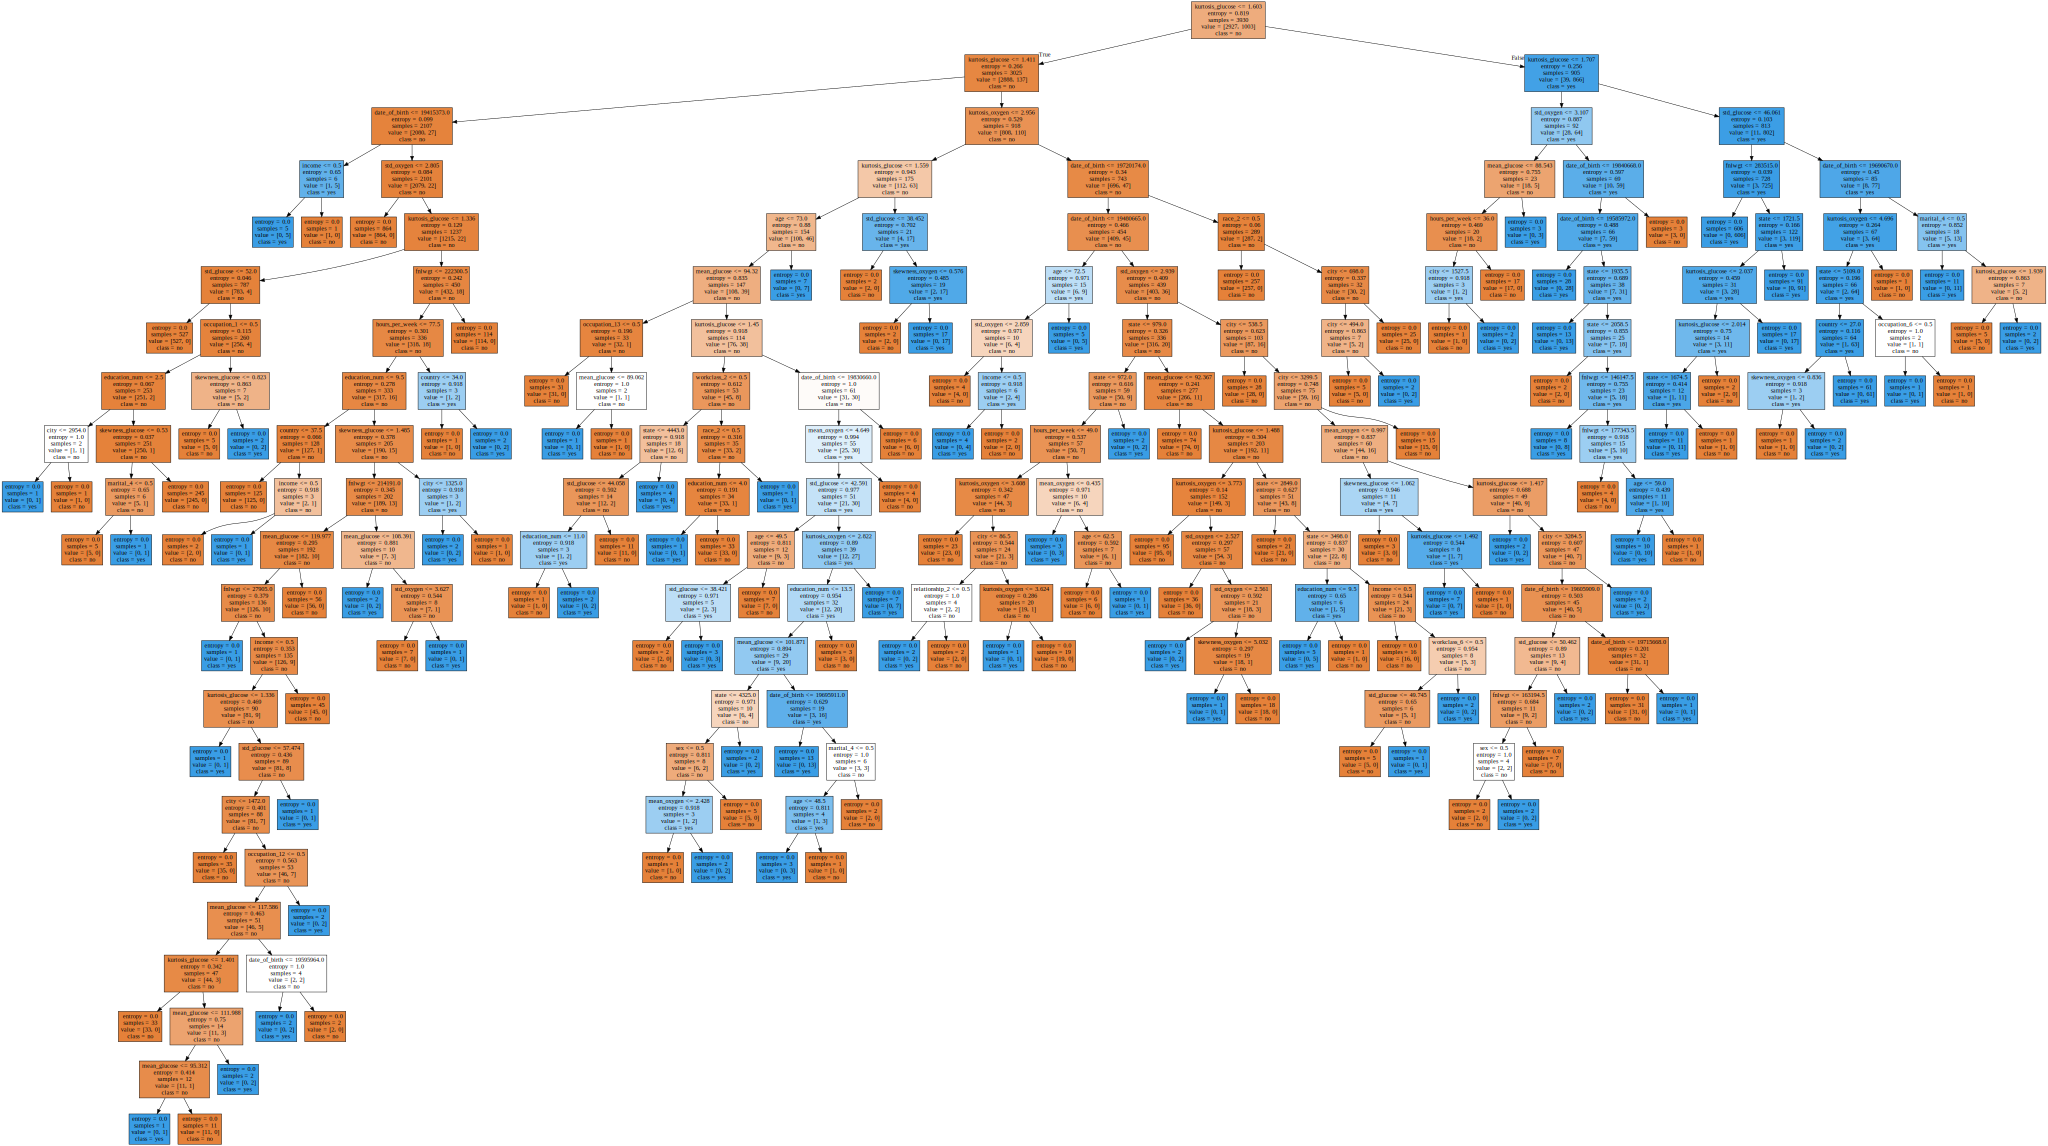

In [62]:
graph = Source(export_graphviz(cls, 
                               out_file=None,
                               feature_names=X_train.columns,
                               class_names=['no', 'yes'],
                              filled = True))

display(SVG(graph.pipe(format='svg')))
style = "<style>svg {max-height:5px !important; max-width:5px !important;}</style>"
HTML(style)

Zo znázorneného stromu sa po priblížení ťažko čítajú jednotlivé pravidlá. Preto som sa pozrel na dôležitosť jednotlivých atribútov v modeli a vybral som 10 najdôležitejších. Ide o atribúty, ktoré sa na rozhodovaní podielali významnejšie ako iné atribúty. Nasledujúci vypísaný zoznam ukazuje, že výrazne najväčšiu dôležitosť má atribút *kurtosis_glucose*. Zvyšné atribúty majú koeficient dôležitosti značne nižší.

In [63]:
A = dict(zip(X_train.columns, model.feature_importances_))
A = dict(sorted(A.items(), key=operator.itemgetter(1), reverse=True)[:10])
i=1
for key,value in A.items():
    print ("{}.{} : {}".format(i, key, value))
    i += 1

1.kurtosis_glucose : 0.7586711043821146
2.date_of_birth : 0.03639436677914937
3.kurtosis_oxygen : 0.02786956920425672
4.std_oxygen : 0.020450529902773344
5.state : 0.019210014685665702
6.std_glucose : 0.017678925189340916
7.mean_glucose : 0.01690324615642105
8.city : 0.014561003176594173
9.fnlwgt : 0.012279204652526904
10.age : 0.010786454725011156


### 3.3. Optimalizácia hyperparametrov
---
#### Preskúmanie hyperparametrov
Na preskúmanie hyperparametrov využijem GridSearch. Do hľadania som sa rozhodol zahrnúť najdôležitejšie parametre, ako je maximálna hĺbka stromu(max_depth), kritérium výberu atribútu pre delenie vzorky(criterion) a minimálny počet vzoriek, ktoré musia byť v liste(min_samples_leaf).

In [64]:
clf = DecisionTreeClassifier

cv_params = {'max_depth': list(range(1,22,1)), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1,2,3,4,5,6]}
ind_params = {'random_state': 0}
optimization = GridSearchCV(clf(**ind_params), 
                            cv_params, 
                             scoring = 'f1_macro', cv = 10, n_jobs = -1, verbose=True)

In [ ]:
optimization.fit(X_train, Y_train)

Fitting 10 folds for each of 252 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:    5.1s


**Parametre najlepšieho modelu**

Po preskúmaní parametrov s použitím GridSearch si ukladám najlepší model. Nasledujúca tabuľka obsahuje nastavenie hyperparametrov vybraneho modelu.

In [ ]:
clf_best = optimization.best_estimator_

In [ ]:
clf_best

|**Názov parametru**|**Hodnota parametru**|**Popis parametru**                                    |
|:-----------------:|:-------------------:|:-----------------------------------------------------:|
|criterion          |gini                 |kritérium výberu atribútu pre delenie vzorky           |
|max_depth          |4                    |určuje maximálnu hĺbku stromu                          |
|min_samples_leaf   |5                    |určuje minimálny počet vzoriek, ktoré musia byť v liste|

**Metriky najlepšieho modelu**

Pre najlepší model vieme určiť jeho priemerné skóre krížovej validácie.

In [ ]:
optimization.best_score_

#### Natrénovanie najlepšieho modelu
Vybraný model s optimalizovanými parametrami natrénujem a vytvorím predikciu nad validačnými dátami. Nakoniec vypočítam metriky(*precision, accuracy, recall, F1*).

In [ ]:
Y_train = data_train['class']
X_train = data_train.drop(['class'],axis=1)
model = clf_best.fit(X_train, Y_train)
Y_valid = data_valid['class']
X_valid = data_valid.drop(['class'],axis=1)
pred = model.predict(X_valid)
print("Precision score: ",precision_score(Y_valid, pred))
print("Accuracy score : ",accuracy_score(Y_valid, pred))
print("Recall score   : ",recall_score(Y_valid, pred))
print("F1 score       : ",f1_score(Y_valid, pred))

Vytvorený rozhodovací strom opäť vykreslím. Môžeme si všimnúť vplyv parametru *max_depth=4*, kde skutočne vidíme že strom rastie len do hĺbky 4 a rozhodovacie kritérium je nastavené na *gini*.

In [ ]:
graph = Source(export_graphviz(model, 
                               out_file=None,
                               feature_names=X_train.columns,
                               class_names=['no', 'yes'],
                              filled = True))

display(SVG(graph.pipe(format='svg')))

style = "<style>svg{min-width:1000px !important;max-height:4000px !important;}</style>"
HTML(style)

Môžeme sa pozrieť aj na vyhodnotenie najdôležitejších atribútov modelu. Aj v tomto prípade má najväčšiu dôležitosť atribút *kurtosis_glucose*. Pri všetkých ostatných atribútoch je ich hodnota nízka.

In [ ]:
A = dict(zip(X_train.columns, model.feature_importances_))
A = dict(sorted(A.items(), key=operator.itemgetter(1), reverse=True)[:10])
i=1
for key,value in A.items():
    print ("{}.{} : {}".format(i, key, value))
    i += 1

### 3.4 10-násobná krížová validácia
---
Aby sme overili rozdiel medzi modelom bez optimalizovaných parametrov a modelom s optimalizovanými parametrami, využijeme krížovú validáciu.

In [ ]:
predict = data_train['class']
features = data_train.drop(['class'],axis=1)

Najprv vykonáme krížovú validáciu s použitím obyčajného modelu, pre ktorý bolo nastavené len kritérium na *entropy*.

In [ ]:
cls = DecisionTreeClassifier(criterion='entropy')
scores = cross_val_score(cls, features, predict, cv=10, scoring = 'accuracy')
scores.mean()

Následne vykonáme 10-násobnú krížovú validáciu nad modelom s nastavenými, optimálnymi hyperparametrami. Aj v tomto, aj v predchádzajúcom prípade vypisujem priemerné skóre, ktoré bolo dosiahnuté pri CV.

In [ ]:
scores = cross_val_score(clf_best, features, predict, cv=10, scoring = 'accuracy')
scores.mean()

Zo zobrazených priemerných hodnôt skóre možeme vidieť, že model s optimálnym nastavením hyperparametrov dosiahol lepšie skóre pre metriku *accuracy* o vyše 0.02. To potvrdzuje, že optimalizácia hyperparametrov má vplyv na správnosť modelu. 

# Záver
---


Týmto projektom bol odprezentovaný postup analýzy získaných dát, ich predspracovanie až po fázu strojového učenia. Samotná analýza údajov môže siahať ešte hlbšie, kedy je možné vyhodnocovať aj závislostí rôznych atribútov(párová analýza, korelácia). Ja som sa v analýze zameral predovšetkým na hľadanie chýb v dátach, ktoré bolo potrebné z datasetu odstrániť.

V rámci predspracovania dát boli odprezentované techniky, ktoré sa v praxi uplatňujú. Mnohé atribúty nemali vhodné rozdelenia, čo by mohlo mať dopad na trénovanie modelu a bolo potrebné ich upraviť. Na identifikáciu týchto problémov nám pomohli histogramy a boxploty, a na riešenie bol použitý buď logaritmus alebo odmocnina. V rámci predspracovania bolo potrebné riešiť aj dopĺňanie chýbajúcich hodnôt, ktoré som realizoval dopĺňaním mediánu alebo priemerom. Dôležitou súčasťou predspracovania bola demonštrácia funkcií *fit* a *transform*, ktoré sú kľúčové pre vykonanie korektného predspracovania. 

V poslednej fáze, ktorá bola orientovaná na strojové učenie, som použil rozhodovací strom ako model na predikciu ochorenia cukrovky. Zameral som sa na metriky modelu, a pomocou GridSearch som sa pokúsil nájsť najlepšie nastavenie hyperparametrov modelu. Pre porovnanie vplyvu optimalizácie hyperparametrov som použil 10-násobnú krížovú validáciu, na model bez optimalizovancýh parametrov a na najlepší nájdený model. CV som vyhodnotil metrikou accuracy, a pri modeli s optimalizovanými parametrami bolo možné pozorovať zlepšenie.